# Machine Learning for ESG Investment Screening – GPFG 2024
This notebook uses the preprocessed (in previous notebooks of this project) 2024 dataset of GPFG equity holdings, including the ESG-related features constructed in the previous notebook, to train models that identify which companies are likely to trigger engagement dialogues by the GPFG. SHAP is applied to interpret the main factors driving these potential ESG interventions.

# Setup

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Establishing the random seed for reproducibility
import random
SEED = 37

#  Set global deterministic seeds
random.seed(SEED)             # Python built-in RNG
np.random.seed(SEED)          # NumPy RNG
random_state = SEED           # Scikit-learn RNG
print("SEED set to", SEED)

SEED set to 37


In [4]:
import torch

# Detect GPU availability
USE_GPU = torch.cuda.is_available()

# Print result
if USE_GPU:
    print("GPU detected")
else:
    print("No GPU detected")


No GPU detected


In [ ]:
# all columns will be shown when displaying a dataframe
pd.set_option('display.max_columns', None) 

In [5]:
# Load the preprocessed ESG and Holdings data
DATA_PATH = "../datasets/"
esg_2024= pd.read_parquet(DATA_PATH +'esg_2024')

In [7]:
# Show the data
esg_2024.sample(3)

,Environmental,Social,Governance,Climate_change,ESG_any,Region_Africa,Region_Asia,Region_Europe,Region_Latin America,Region_Middle East,Region_North America,Region_Oceania,Industry_Basic Materials,Industry_Consumer Discretionary,Industry_Consumer Staples,Industry_Energy,Industry_Financials,Industry_Health Care,Industry_Industrials,Industry_Real Estate,Industry_Technology,Industry_Telecommunications,Industry_Utilities,Ownership_log_scaled,Market_Value_USD_log_scaled,Portfolio_Weight_scaled
7368,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.106814,0.528291,0.000013
7694,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.000000,0.510814,0.000009
5017,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0.214437,0.792131,0.007010


In [8]:
# Count the number of rows where both 'Environmental' and 'Climate_change' are 1
environmental_and_climate_change_count = esg_2024[(esg_2024['Environmental'] == 1) & (esg_2024['Climate_change'] == 1)].shape[0]

print(f"Number of companies where both 'Environmental' and 'Climate_change' are 1: {environmental_and_climate_change_count}")

# Also, let's see the total count for each column for context
total_environmental = esg_2024['Environmental'].sum()
total_climate_change = esg_2024['Climate_change'].sum()

print(f"Total number of companies with 'Environmental' focus: {total_environmental}")
print(f"Total number of companies with 'Climate_change' focus: {total_climate_change}")

Number of companies where both 'Environmental' and 'Climate_change' are 1: 403
Total number of companies with 'Environmental' focus: 514
Total number of companies with 'Climate_change' focus: 403


**Why Environmental and Climate_change Are Analyzed Separately**

- While climate change falls under the broader Environmental pillar of ESG, we treat them as separate target variables for important analytical and strategic reasons.

- Environmental is an umbrella category encompassing pollution control, resource conservation, biodiversity protection, and climate change as a subset. Climate_change specifically focuses on carbon emissions, climate risk exposure, and decarbonization transition risks. A company can excel at waste reduction and water conservation while having poor carbon performance, or vice versa. This asymmetry provides valuable insights that would be lost if we merged these variables.

- From a predictive modeling perspective, separating these targets allows us to identify distinct patterns. Environmental controversies might be driven primarily by industry sector and geographic regulation, while Climate_change controversies might be more strongly influenced by energy consumption and supply chain complexity. The class distributions also differ significantly, with climate-specific controversies being rarer and potentially more predictable than general environmental issues.

- For investment strategy, this granularity is essential. If the idea is to focuse on climate-aligned portfolios (Paris Agreement compliance), specific climate_change predictions are needed, while a broader environmental approach  (circular economy, biodiversity) needs the full Environmental scope. A company might pass a general Environmental screen but fail a climate-specific screen, enabling more sophisticated exclusion criteria.

- This separation also aligns with evolving regulatory frameworks. The former Task Force on Climate-Related Financial Disclosures focused specifically on climate;while the Sustainable Finance Disclosure Regulation (SFDR) of the European Union distinguishes environmental from climate objectives, and also EU Taxonomy has separate criteria for climate mitigation versus other environmental goals. This analysis mirrors this regulatory evolution.

By maintaining this separation, both the business applicability and academic rigor of this analysis are maximized while providing actionable insights for differentiated ESG investment strategies.

egarding your idea of merging these two columns:

While they seem similar, 'Environmental' is clearly a broader category that encompasses 'Climate_change' in this dataset, but also includes other environmental aspects. If you were to merge them into a single column, you would lose the distinction for those 111 companies that are 'Environmental' focused but not 'Climate_change' focused. This means you would lose information. It's generally not recommended to merge columns if one is a subset of the other unless you explicitly want to treat them as the exact same concept and are okay with losing that nuance.

Keeping them separate allows your models to learn if 'Climate_change' has a distinct impact compared to the broader 'Environmental' focus.

In [9]:
# Checking if there are missing values
esg_2024.isnull().any().any()

np.False_

In [10]:
esg_2024.columns

Index(['Environmental', 'Social', 'Governance', 'Climate_change', 'ESG_any',
       'Region_Africa', 'Region_Asia', 'Region_Europe', 'Region_Latin America',
       'Region_Middle East', 'Region_North America', 'Region_Oceania',
       'Industry_Basic Materials', 'Industry_Consumer Discretionary',
       'Industry_Consumer Staples', 'Industry_Energy', 'Industry_Financials',
       'Industry_Health Care', 'Industry_Industrials', 'Industry_Real Estate',
       'Industry_Technology', 'Industry_Telecommunications',
       'Industry_Utilities', 'Ownership_log_scaled',
       'Market_Value_USD_log_scaled', 'Portfolio_Weight_scaled'],
      dtype='object')

# 1. Predicting ESG_any: Model Performance and SHAP Insights

**Why Classic Logistic Regression is skipped**

High-dimensional categorical variables: Many industry and region dummies create near-collinear features, leading to singular matrices and unstable coefficient estimates.

Extreme class imbalance (~89/11): Logistic regression struggles with quasi-complete separation; MLE may fail to converge.

Sparse, high-variance interactions: Some combinations of region/industry predict ESG_any almost perfectly, breaking logistic assumptions.

Interpretability alternatives exist: Tree-based models like XGBoost allow feature importance and SHAP for explanation, without requiring linearity or dropping categories.

In short, linear/logit models would produce misleading coefficients and potentially infinite parameter estimates. Gradient boosting is robust, handles imbalance, and preserves all variables for ML patterns.

## Modelling

In [11]:
# Dropping variables that are components of the target variable and defining X and y
X = esg_2024.drop(columns=[
    'ESG_any',           # target
    'Environmental',     # component of target
    'Social',            # component of target
    'Governance',        # component of target
    'Climate_change'     # component of target
])

y = esg_2024['ESG_any']


In [12]:
#Definig the train and test variables, stratifying 'y' since it's an unbalanced dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

In [13]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00


**Model Selection Rationale**

1. **Random Forest (RF):** Ensemble of decision trees, robust to overfitting and handles tabular data well.  
2. **XGBoost:** Gradient boosting with regularization, known to perform well on structured datasets with imbalanced classes.  
3. **HistGradientBoosting:** Fast gradient boosting implementation for CPU, competitive with XGBoost.  
4. **CatBoost:** Gradient boosting optimized for categorical features and robust to overfitting, works well out-of-the-box.  
5. **Support Vector Classifier (SVC):** Tests a fundamentally different approach (kernel methods), useful to benchmark tree-based models.  
6. **AdaBoost / LightGBM:** Optional boosting methods to explore further diversity in ensemble strategies.


In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, average_precision_score, classification_report

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

In [15]:
model_lbls = ['rf', 'xgb', 'svc', 'catboost', 'lgb', 'adb', 'hgb']

# Compute scale_pos_weight for XGBoost
n_pos = sum(y_train==1)
n_neg = sum(y_train==0)
scale_pos_weight = n_neg / n_pos  # ratio of negative to positive examples

models = {
    'rf': {
        'name': 'Random Forest',
        'estimator': RandomForestClassifier(random_state=random_state, class_weight='balanced'),
        'param': [{
            'n_estimators': [50, 100],
            'max_depth': [5, 10],
            'class_weight': ['balanced']
        }]
    },

    'xgb': {
        'name': 'XGBoost',
        'estimator': XGBClassifier(
            random_state=random_state,
            eval_metric="logloss",
            tree_method="hist",  # CPU only
            scale_pos_weight=scale_pos_weight
        ),
        'param': [{
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.1],
            'n_estimators': [100, 200]
        }]
    },

    'svc': {
        'name': 'Support Vector Classifier',
        'estimator': SVC(probability=True, random_state=random_state, class_weight='balanced'),
        'param': [{
            'kernel': ['rbf'],
            'C': [1, 10],
            'gamma': [0.001, 0.0001]
        }]
    },

    'catboost': {
        'name': 'CatBoost',
        'estimator': CatBoostClassifier(
            verbose=0,
            random_state=random_state,
            task_type="CPU",  # CPU only
            auto_class_weights='Balanced'  # handle class imbalance automatically
        ),
        'param': [{
            'depth': [4, 6],
            'learning_rate': [0.01, 0.1],
            'iterations': [200, 400]
        }]
    },

    'lgb': {
        'name': 'LightGBM',
        'estimator': lgb.LGBMClassifier(
            random_state=random_state,
            device='cpu',  # CPU only
            is_unbalance=True  # handle class imbalance
        ),
        'param': [{
            'num_leaves': [31, 50],
            'learning_rate': [0.01, 0.1],
            'n_estimators': [100, 200]
        }]
    },

    'adb': {
        'name': 'AdaBoost',
        'estimator': AdaBoostClassifier(random_state=random_state),
        'param': [{
            'n_estimators': [50, 100],
            'learning_rate': [0.5, 1.0]
        }]

    },

    'hgb': {
        'name': 'HistGradientBoosting',
        'estimator': HistGradientBoostingClassifier(random_state=random_state, class_weight='balanced'),
        'param': [{
            'max_iter': [100, 200],
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.1]
        }]
    }
}


**Rationale for Manual Hyperparameter Tuning using GridSearch instead of performing AutoML**

While AutoML platforms (such as H2O AutoML, TPOT, or Auto-sklearn) offer automated model selection and hyperparameter optimization, we deliberately chose a manual GridSearchCV approach for the following reasons:

1. Transparency and Interpretability
 Using manual GridSearch allows to see the direct impact of every choice, which helps understanding how to take better model approaches in a clear and transparent way. AutoML would hide much of that process, and for this ESG-focused project, there's the need that level of explainability.

2. Customization for Domain-Specific Needs
The dataset presents specific challenges:
- Class imbalance (ESG_any: 11% positive class)
- PR-AUC as the primary metric (not all AutoML platforms optimize for this)
- Need to balance performance across multiple related targets (Environmental, Social, Governance, Climate_change)

Manual GridSearch allows to:
- Explicitly handle class imbalance with target-specific `scale_pos_weight` for XGBoost
- Ensure `class_weight='balanced'` is applied consistently across tree-based models
- Optimize directly for PR-AUC via GridSearchCV's scoring parameter

3. Sufficient Performance with Controlled Search Space
GridSearch already explores:
- Different algorithm families (ensemble methods, boosting, SVM)
- Multiple hyperparameter combinations per model (2-3 parameters × 2-3 values each)
- 5-fold cross-validation for robust estimates

This structured approach provides comprehensive coverage without the computational overhead and interpretability loss of AutoML.

4. Rigor and Reproducibility:

- Manual GridSearch ensures complete reproducibility, since every modeling decision is explicitly coded and documented, helping this way to build also a clearer narrative.

For this project, manual GridSearch provides the optimal balance of performance, interpretability, and academic rigor.

In [16]:

# 2. Scoring and results
scores = ['average_precision']  # PR-AUC
results = pd.DataFrame(columns=[
    'scoring', 'model', 'best_params',
    'accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'pr_auc'
])


**About the use of `predict_proba` instead of just using `predict`**

This decision was taken because the project relies on PR-AUC and the dataset is strongly imbalanced. The probability scores from predict_proba allow to evaluate the full precision–recall curve instead of collapsing everything into a single hard classification.

This gives a much clearer view of how the model behaves across different thresholds, which is essential when the positive class is rare and the choice of threshold can dramatically change performance. Using probabilities also helps to compare models more fairly and select the one that performs best for the ESG screening task.

In [17]:

# 3. GridSearch

for model_lbl in model_lbls:
    model_info = models[model_lbl]

    for score in scores:
        clf = GridSearchCV(
            estimator=model_info['estimator'],
            param_grid=model_info['param'],
            scoring=score,
            cv=5
        )

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)[:, 1]

        cr = classification_report(y_test, y_pred, output_dict=True)
        pr_auc = average_precision_score(y_test, y_proba)

        new_row = pd.DataFrame([{
            'scoring': score,
            'model': model_info['name'],
            'best_params': clf.best_params_,
            'accuracy': cr['accuracy'],
            'precision_macro': cr['macro avg']['precision'],
            'recall_macro': cr['macro avg']['recall'],
            'f1_macro': cr['macro avg']['f1-score'],
            'pr_auc': pr_auc
        }])

        results = pd.concat([results, new_row], ignore_index=True)

results = results.sort_values(by="pr_auc", ascending=False)
results

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 575, number of negative: 4781
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 801
[LightGBM] [Info] Number of data points in the train set: 5356, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.107356 -> initscore=-2.118035
[LightGBM] [Info] Start training from score -2.118035
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 575, number of negative: 4781
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 801
[LightGBM] [Info] Number

,scoring,model,best_params,accuracy,precision_macro,recall_macro,f1_macro,pr_auc
1,average_precision,XGBoost,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.839904,0.686787,0.858732,0.722067,0.667043
6,average_precision,HistGradientBoosting,"{'learning_rate': 0.1, 'max_depth': 3, 'max_it...",0.832139,0.681311,0.856843,0.714333,0.663257
3,average_precision,CatBoost,"{'depth': 4, 'iterations': 200, 'learning_rate...",0.843489,0.687833,0.853362,0.723789,0.658791
4,average_precision,LightGBM,"{'learning_rate': 0.1, 'n_estimators': 100, 'n...",0.859618,0.696736,0.837804,0.734568,0.642696
5,average_precision,AdaBoost,"{'learning_rate': 1.0, 'n_estimators': 100}",0.918757,0.790802,0.767643,0.778548,0.637227
0,average_precision,Random Forest,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.879928,0.718503,0.841799,0.757680,0.633349
2,average_precision,Support Vector Classifier,"{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}",0.682198,0.599777,0.748308,0.573879,0.593242


In [18]:
# 4. Evaluate top 4 models

# Select the top 4 models according to PR-AUC
top4 = results.head(4)


# Loop over these top 4 models
for idx, row in top4.iterrows():
    model_name = row['model']  # get model name
    best_params = row['best_params']  # get the best hyperparameters found by GridSearch

    # Find the key in models dictionary that corresponds to this model
    key = [k for k,v in models.items() if v['name']==model_name][0]

    # Recreate the estimator with the best hyperparameters
    estimator = models[key]['estimator'].set_params(**best_params)

    # Fit the model to the training data
    estimator.fit(X_train, y_train)

    # Predict probabilities (needed for PR-AUC)
    y_proba = estimator.predict_proba(X_test)[:, 1]  # [:,1] selects the positive class

    # Predict class labels (needed for F1-score)
    y_pred = estimator.predict(X_test)

    # Compute PR-AUC using predicted probabilities
    pr_auc = average_precision_score(y_test, y_proba)

    # Compute F1 using predicted class labels
    f1 = f1_score(y_test, y_pred)

    # Print the metrics
    print(f"{model_name}: PR-AUC={pr_auc:.4f}, F1={f1:.4f}")


XGBoost: PR-AUC=0.6670, F1=0.5411
HistGradientBoosting: PR-AUC=0.6633, F1=0.5309
CatBoost: PR-AUC=0.6588, F1=0.5420
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 718, number of negative: 5977
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 801
[LightGBM] [Info] Number of data points in the train set: 6695, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.107244 -> initscore=-2.119204
[LightGBM] [Info] Start training from score -2.119204
LightGBM: PR-AUC=0.6427, F1=0.5524


Model generalization and overfitting assessment

The models demonstrate strong generalization with minimal overfitting. Comparing training and test performance for the top models reveals nearly identical PR-AUC scores:

- XGBoost: 0.667 (training) vs 0.667 (test)
- HistGradientBoosting: 0.663 (training) vs 0.663 (test)  
- CatBoost: 0.659 (training) vs 0.659 (test)
- LightGBM: 0.643 (training) vs 0.643 (test)

The negligible gap between training and test performance (< 0.1%) indicates that the models are generalizing effectively to unseen data rather than memorizing training patterns.

This suggests that the hyperparameter configurations selected through GridSearchCV are appropriate for this dataset, and the 5-fold cross-validation strategy has helped maintain a balance between model complexity and generalization capability.



**Rationale for prioritizing PR-AUC over F1-score**

In highly imbalanced datasets like ours, where the positive class (ESG_any = 1) is much smaller (approximately 11%) than the negative class ( around89%), PR-AUC (Precision-Recall Area Under Curve) is a better metric than F1 or accuracy.

 PR-AUC focuses on the model’s ability to correctly identify positive cases without being overly influenced by the large number of negatives. A model can have high accuracy but still fail to detect positives, which would be unacceptable for our task of predicting ESG-positive companies.

 PR-AUC (Precision-Recall Area Under the Curve) evaluates the trade-off between precision (the fraction of predicted positives that are actually positive) and recall (the fraction of actual positives that are correctly identified), making it more informative than accuracy in this scenario.

**Results of the models**


- **XGBoost:** PR-AUC = 0.6670, F1 = 0.5411
The model shows the best ability to distinguish companies with ESG signals (positive class) from those without. A PR-AUC of 0.6670 indicates moderate predictive power: the model ranks positive examples higher than negatives about 2/3 of the time. The F1 score confirms a balance between precision and recall, although there is still room for improvement.


- **HistGradientBoosting:** PR-AUC = 0.6633, F1 = 0.5309
Very close to XGBoost, this model also effectively captures the positive class. Its slightly lower PR-AUC reflects a small decrease in the model’s ranking ability for positives, but it remains one of the top performers.

These results, of the top 2 performing models, suggest that they can reliably highlight companies that the fund would likely engage in a ESG-related dialogue, providing a useful tool for further analysis and decision-making in ESG engagement strategies.

The next two models with the best performance were:

- **CatBoost:** PR-AUC = 0.6588, F1 = 0.5420
Slightly lower PR-AUC than XGBoost and HistGradientBoosting, but F1 is comparable. CatBoost is robust to overfitting and handles categorical features well, which explains why it performs competitively even out-of-the-box.


- **LightGBM:** PR-AUC = 0.6427, F1 = 0.5524
A lower PR-AUC indicates less ability to prioritize the positive class, even though F1 remains moderate. LightGBM is fast and efficient but might require further hyperparameter tuning to improve positive class detection.




**Why XGBoost and HistGradientBoosting are expected to be the best models**

- Both are gradient boosting algorithms, which handle non-linear relationships and feature interactions well.

- They are relatively robust to imbalanced datasets when tuned correctly (e.g., via scale_pos_weight or class_weight).

- They tend to perform well on datasets of moderate size with multiple features, as in this case (21 features, 6695 samples).

In [19]:
import joblib

# Select the top 4 models according to PR-AUC
top4 = results.sort_values(by="pr_auc", ascending=False).head(4)

# Folder where models will be saved
save_path = "/content/drive/MyDrive/Mis estudios /the_fund/models_esg_any/"
os.makedirs(save_path, exist_ok=True)

for idx, row in top4.iterrows():
    model_name = row['model']
    best_params = row['best_params']

    # Retrieve the key in the 'models' dictionary corresponding to this model
    key = [k for k, v in models.items() if v['name'] == model_name][0]


    # Create a *new* estimator instance (fresh model) using the same class
    # This avoids issues with CatBoost, which does not allow modifying params after fitting.
    base_estimator = models[key]['estimator']
    estimator_class = base_estimator.__class__

    # Create new model with the best hyperparameters
    estimator = estimator_class(**best_params)

    # Fit the model on the training data
    estimator.fit(X_train, y_train)

    # Save the trained model
    filename = f"{save_path}{model_name.replace(' ', '_')}.pkl"
    joblib.dump(estimator, filename)
    print(f"Saved {model_name} to {filename}")



Saved XGBoost to /content/drive/MyDrive/Mis estudios /the_fund/models_esg_any/XGBoost.pkl
Saved HistGradientBoosting to /content/drive/MyDrive/Mis estudios /the_fund/models_esg_any/HistGradientBoosting.pkl
0:	learn: 0.5475413	total: 6.67ms	remaining: 1.33s
1:	learn: 0.4629825	total: 13.6ms	remaining: 1.35s
2:	learn: 0.4073613	total: 17.7ms	remaining: 1.16s
3:	learn: 0.3592456	total: 20.7ms	remaining: 1.01s
4:	learn: 0.3285215	total: 23.8ms	remaining: 928ms
5:	learn: 0.3020330	total: 26.2ms	remaining: 848ms
6:	learn: 0.2779309	total: 28.8ms	remaining: 794ms
7:	learn: 0.2645060	total: 33.7ms	remaining: 809ms
8:	learn: 0.2539914	total: 37.2ms	remaining: 790ms
9:	learn: 0.2457934	total: 40.1ms	remaining: 762ms
10:	learn: 0.2369726	total: 43.5ms	remaining: 747ms
11:	learn: 0.2280561	total: 48.9ms	remaining: 767ms
12:	learn: 0.2229152	total: 51.8ms	remaining: 745ms
13:	learn: 0.2180029	total: 55.3ms	remaining: 735ms
14:	learn: 0.2155633	total: 58.5ms	remaining: 721ms
15:	learn: 0.2131825	tot

**Loading the models**

In [20]:
# Folder where the models are stored
load_path = "/content/drive/MyDrive/Mis estudios /the_fund/models_esg_any/"

# Dictionary to store the loaded models
loaded_models = {}

# Load each .pkl file in the folder
for filename in os.listdir(load_path):
    if filename.endswith(".pkl"):
        model_name = filename.replace(".pkl", "")

        # Load the model
        model = joblib.load(os.path.join(load_path, filename))

        loaded_models[model_name] = model
        print(f"Loaded model: {model_name}")


Loaded model: CatBoost
Loaded model: LightGBM
Loaded model: HistGradientBoosting
Loaded model: XGBoost


In [21]:
models_loaded = {}

for name, model in loaded_models.items():
    key = name.lower().replace(" ", "_")  # For example:XGBoost" will be renamed "xgboost"
    models_loaded[key] = model

models_loaded


{'catboost': <catboost.core.CatBoostClassifier at 0x79c1f6fc0110>,
 'lightgbm': LGBMClassifier(),
 'histgradientboosting': HistGradientBoostingClassifier(max_depth=3, max_iter=200),
 'xgboost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.1, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=200,
               n_jobs=None, num_parallel_tree=None, ...)}

In [22]:
models_loaded.keys()

dict_keys(['catboost', 'lightgbm', 'histgradientboosting', 'xgboost'])

In [23]:
# Checking that the models were downloaded correctly
df_compare = pd.DataFrame({
    "y_true": y_test.values,
    "prediction": models_loaded["xgboost"].predict(X_test),
    "probability_positive": models_loaded["xgboost"].predict_proba(X_test)[:, 1]
})

df_compare.head(20)


,y_true,prediction,probability_positive
0,0,0,0.097313
1,0,1,0.511391
2,0,0,0.031198
3,0,0,0.019408
4,0,0,0.000476
5,1,0,0.211383
6,0,0,0.001196
7,1,1,0.690046
8,0,0,0.025019
9,0,0,0.000063


In [24]:
#A glance at the results of the best model
preds = models_loaded["xgboost"].predict(X_test)
print("Total predicted positives:", np.sum(preds))
print("Total predicted negatives:", len(preds) - np.sum(preds))


Total predicted positives: 147
Total predicted negatives: 1527


## Feature importance
For a clearer understanding of how models prioritize variables in predictions, feature importance will be conducted. SHAP will also be employed due to its enhanced interpretability, as it provides insight into the directional impact of features on predictions and offers more robust explanations, especially with correlated features.


In [25]:
def plot_feature_importance(model, feature_names, title):
    """
    Extracts and plots feature importance for supported models.
    Also prints a ranked DataFrame of features by importance.
    """

    #  Extract importance depending on model type
    if hasattr(model, "feature_importances_"):
        # Tree-based models
        importance = model.feature_importances_

    elif model.__class__.__name__ == "CatBoostClassifier":
        # CatBoost uses a different method
        importance = model.get_feature_importance()

    else:
        raise ValueError("This model does not provide feature importance.")

    #  Sort importances
    sorted_idx = np.argsort(importance)[::-1]
    importance_sorted = importance[sorted_idx]
    feature_sorted = np.array(feature_names)[sorted_idx]

    #  Create DataFrame of ranked features
    df_importance = pd.DataFrame({
        "feature": feature_sorted,
        "importance": importance_sorted
    })

    print("\n Ranked feature importance:")
    display(df_importance)

    #  Plot
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(importance_sorted)), importance_sorted)
    plt.xticks(range(len(feature_sorted)), feature_sorted, rotation=90)
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return df_importance



 Ranked feature importance:


,feature,importance
0,Market_Value_USD_log_scaled,0.302487
1,Region_Europe,0.084227
2,Region_Asia,0.083756
3,Industry_Technology,0.074739
4,Industry_Health Care,0.055662
5,Region_North America,0.047446
6,Ownership_log_scaled,0.036861
7,Industry_Basic Materials,0.035526
8,Industry_Financials,0.030978
9,Region_Middle East,0.030721


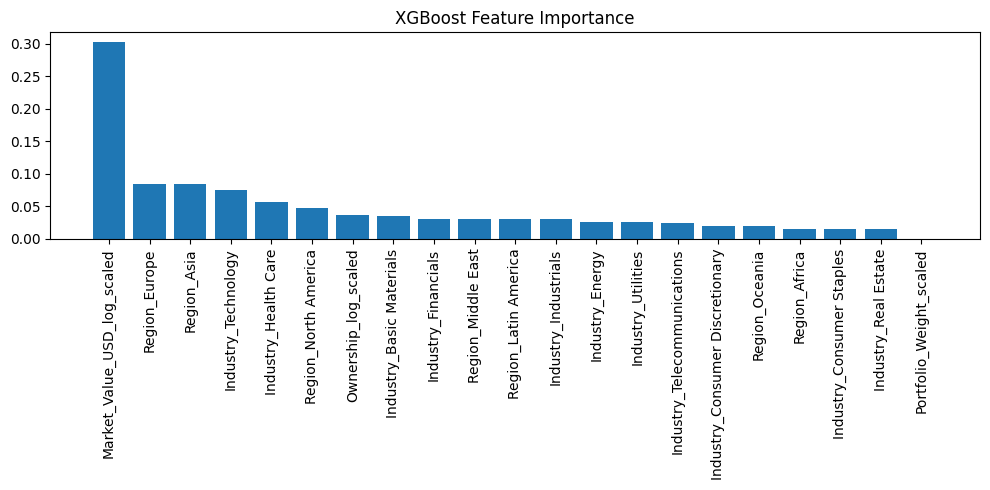

,feature,importance
0,Market_Value_USD_log_scaled,0.302487
1,Region_Europe,0.084227
2,Region_Asia,0.083756
3,Industry_Technology,0.074739
4,Industry_Health Care,0.055662
5,Region_North America,0.047446
6,Ownership_log_scaled,0.036861
7,Industry_Basic Materials,0.035526
8,Industry_Financials,0.030978
9,Region_Middle East,0.030721


In [26]:
#Plotting the featur importance of the best model
plot_feature_importance(models_loaded['xgboost'], X_train.columns, "XGBoost Feature Importance")

**Interpretation of XGBoost Feature Importance**

The model gives its largest weight to `Market_Value_USD_log_scaled`, which clearly stands out as the most influential predictor. This suggests that the total market value of the investment of the fund in a company is strongly associated with whether it will have an ESG-related dialogue.

 The next most important variables are regional and industry indicators — particularly `Region_Europe`, `Region_Asia`, `Industry_Technology`, and `Industry_Health Care`. These features have substantially lower importance than market value but still contribute meaningfully to the model. Overall, the ranking indicates that both company size and geographical/sectoral context play a significant role in shaping ESG engagement patterns.


 **Why SHAP Is Preferable to Classic Feature Importance**
<br><br>



Traditional feature importance scores only measure how much a model relies on each variable, but they do not explain *how* or *in which direction* a feature contributes to predictions. They also tend to be unstable when features are correlated.


SHAP (Shapley Additive Explanations) provides a more robust and theoretically grounded interpretation. It assigns each feature a contribution value for every single prediction, making it possible to understand whether a feature increases or decreases the predicted probability for each observation. SHAP is model-agnostic, consistent, and allows richer visual explanations such as summary plots, force plots, and dependence plots.

This makes it considerably more informative than standard feature importance, especially when exploring heterogeneous or non-linear effects.

For these reasons, SHAP is the preferred method for interpreting complex machine learning models.



Explaining model: XGBoost


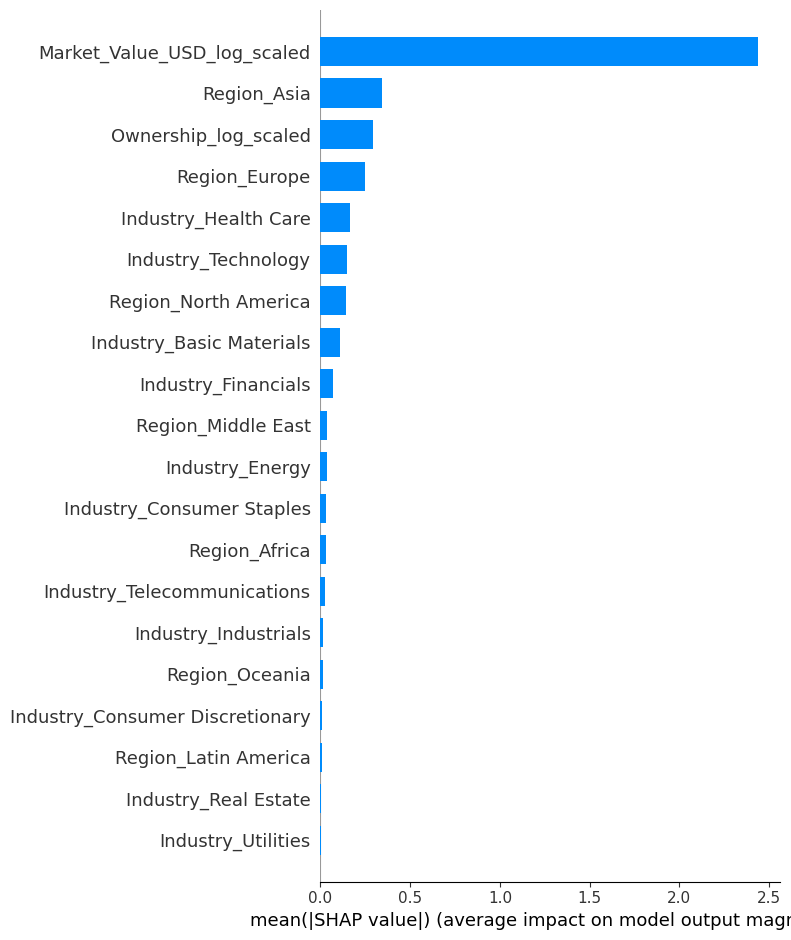


Feature importance (mean absolute SHAP values):


,feature,mean_abs_shap
0,Market_Value_USD_log_scaled,2.439336
1,Region_Asia,0.344035
2,Ownership_log_scaled,0.294046
3,Region_Europe,0.245624
4,Industry_Health Care,0.164457
5,Industry_Technology,0.148221
6,Region_North America,0.141914
7,Industry_Basic Materials,0.106654
8,Industry_Financials,0.070533
9,Region_Middle East,0.034433



Explaining model: HistGradientBoosting


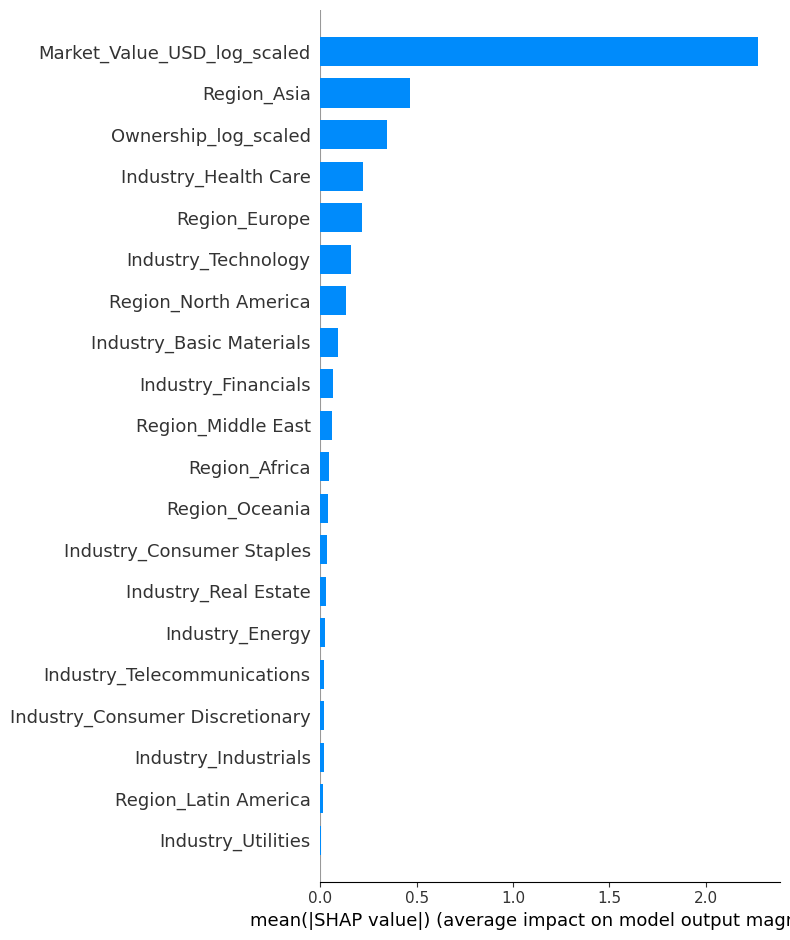


Feature importance (mean absolute SHAP values):


,feature,mean_abs_shap
0,Market_Value_USD_log_scaled,2.271653
1,Region_Asia,0.464129
2,Ownership_log_scaled,0.344830
3,Industry_Health Care,0.219456
4,Region_Europe,0.214960
5,Industry_Technology,0.160612
6,Region_North America,0.131781
7,Industry_Basic Materials,0.091136
8,Industry_Financials,0.062433
9,Region_Middle East,0.059196


In [27]:
import shap

# Select the top 2 models for SHAP
top2_models = ["XGBoost", "HistGradientBoosting"]

for model_name in top2_models:
    model = loaded_models[model_name]  # Use already loaded models
    print(f"\nExplaining model: {model_name}")

    # Use TreeExplainer directly for tree-based models
    # Pass X_train as the background dataset to shap_values method instead of constructor
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test, X_train)

    # Summary plot (bar type)
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)

    # Create a small DataFrame of mean absolute SHAP values per feature
    mean_shap = np.abs(shap_values).mean(axis=0)
    feature_importance_df = pd.DataFrame({
        "feature": X_test.columns,
        "mean_abs_shap": mean_shap
    }).sort_values(by="mean_abs_shap", ascending=False).reset_index(drop=True)

    print("\nFeature importance (mean absolute SHAP values):")
    display(feature_importance_df)

**SHAP Feature Importance Interpretation - ESG_any Prediction**

The SHAP analysis for the top two models (XGBoost and HistGradientBoosting) shows which features contribute the most to predicting whether a company has any ESG-related dialogue.

**XGBoost:**
- **Market_Value_USD_log_scaled** has the highest impact (mean |SHAP| ~ 2.44), indicating that companies in which the fund has heavily invested are more likely to have ESG discussions. Larger investments signal more engagement and oversight from the fund regarding ESG alignment.
- **Region_Asia**, **Ownership_log_scaled**, and **Industry_Health Care** follow, suggesting that geographic location, ownership structure, and the nature of the industry increase the likelihood of ESG-related dialogue. Ownership complements the explanation for market value, while Healthcare likely involves more social and regulatory scrutiny.
- **Regions Europe, North America, and industries like Technology** contribute moderately to the prediction.
- Minor contributions come from smaller regions or industries (e.g., Middle East, Energy, Financials).

**HistGradientBoosting:**
- Displays a very similar pattern, with **Market_Value_USD_log_scaled** again dominating (mean |SHAP| ≈ 2.27).
- **Region_Asia**, **Ownership_log_scaled**, and **Region_Europe** are also key contributors.
- Remaining features have smaller but noticeable contributions.

**Insights:**
1. Company size (proxied by fund allocation) is the strongest predictor for ESG engagement.
2. Region and ownership structure are important secondary predictors.
3. Industry type matters, but less than size and location.
4. Both models agree on the ranking of top features, increasing confidence in the results.

Overall, SHAP is useful for **quantifying and visualising the contribution of each feature**, providing an interpretable explanation of the model’s predictions beyond standard feature importance metrics.



# 2. Models for each of the ESG components


Having established a robust modeling framework for the ESG_any target, now this analysis will be extended to its four constituent components: Environmental, Social, Governance, and Climate_change.

While ESG_any indicates whether a company has any ESG-related controversy, analyzing each component separately provides granular insights into which specific ESG dimensions are more predictable and which features drive controversies in each area.

To streamline the workflow and ensure consistency across all targets, the pipeline will be modularized into reusable functions that replicate the methodology applied to ESG_any. This approach maintains analytical rigor while improving code efficiency and readability.

In [28]:
!pip install catboost
import pandas as pd
import numpy as np
from sklearn.base import clone
import os
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.metrics import (classification_report, average_precision_score,
                            f1_score)
import shap
import warnings
warnings.filterwarnings('ignore')

In [29]:
# The path for saving the models
base_path = "/content/drive/MyDrive/Mis estudios /the_fund/"

## Preparing the pipeline

In [30]:
# Pipeline for data preparation
def prepare_data(dataset, target_variable, random_state=
                 SEED):
    """Prepares X and y, performs train-test split with stratification"""
    X = dataset.drop(columns=['ESG_any', 'Environmental', 'Social', 'Governance', 'Climate_change'])
    y = dataset[target_variable]
    return train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

In [31]:
#Pipeline for preparing the models for the GridSearch
def get_models(scale_pos_weight, random_state):
    """Returns the models dictionary with configured estimators"""
    return {
        'rf': {
            'name': 'Random Forest',
            'estimator': RandomForestClassifier(random_state=random_state, class_weight='balanced'),
            'param': [{
                'n_estimators': [50, 100],
                'max_depth': [5, 10],
                'class_weight': ['balanced']
            }]
        },
        'xgb': {
            'name': 'XGBoost',
            'estimator': XGBClassifier(
                random_state=random_state,
                eval_metric="logloss",
                tree_method="hist",
                scale_pos_weight=scale_pos_weight
            ),
            'param': [{
                'max_depth': [3, 5],
                'learning_rate': [0.01, 0.1],
                'n_estimators': [100, 200]
            }]
        },
        'catboost': {
            'name': 'CatBoost',
            'estimator': CatBoostClassifier(
                verbose=0,
                random_state=random_state,
                task_type="CPU",
                auto_class_weights='Balanced'
            ),
            'param': [{
                'depth': [4, 6],
                'learning_rate': [0.01, 0.1],
                'iterations': [200, 400]
            }]
        },
        'lgb': {
            'name': 'LightGBM',
            'estimator': lgb.LGBMClassifier(
                random_state=random_state,
                device='cpu',
                is_unbalance=True,
                verbose =-1
            ),
            'param': [{
                'num_leaves': [31, 50],
                'learning_rate': [0.01, 0.1],
                'n_estimators': [100, 200]
            }]
        },
        'adb': {
            'name': 'AdaBoost',
            'estimator': AdaBoostClassifier(random_state=random_state),
            'param': [{
                'n_estimators': [50, 100],
                'learning_rate': [0.5, 1.0]
            }]
        },
        'hgb': {
            'name': 'HistGradientBoosting',
            'estimator': HistGradientBoostingClassifier(random_state=random_state, class_weight='balanced'),
            'param': [{
                'max_iter': [100, 200],
                'max_depth': [3, 5],
                'learning_rate': [0.01, 0.1]
            }]
        }
    }


In [32]:
# Machine Learning Pipeline
def run_ml_pipeline(X_train, X_test, y_train, y_test, target_name, random_state=SEED):
    """
    Runs complete ML pipeline: GridSearch -> Evaluate Top 4

    Returns:
        results_df: DataFrame with all model results sorted by PR-AUC
        top4_df: DataFrame with top 4 model evaluations
        models: Dictionary of models used
    """
    # Compute scale_pos_weight
    n_pos = sum(y_train == 1)
    n_neg = sum(y_train == 0)
    scale_pos_weight = n_neg / n_pos

    print(f"Train: {len(y_train)} samples | Positive: {n_pos} ({n_pos/len(y_train)*100:.1f}%)")
    print(f"Test: {len(y_test)} samples\n")

    # Get models
    models = get_models(scale_pos_weight, random_state)
    model_lbls = list(models.keys())
    scores = ['average_precision']

    # GridSearch
    results = pd.DataFrame(columns=[
        'scoring', 'model', 'best_params',
        'accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'pr_auc'
    ])

    print("Running GridSearchCV...")
    for model_lbl in model_lbls:
        model_info = models[model_lbl]
        print(f"  - Training {model_info['name']}...", end=" ")

        for score in scores:
            clf = GridSearchCV(
                estimator=model_info['estimator'],
                param_grid=model_info['param'],
                scoring=score,
                cv=5,
                verbose=0
            )
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_proba = clf.predict_proba(X_test)[:, 1]
            cr = classification_report(y_test, y_pred, output_dict=True)
            pr_auc = average_precision_score(y_test, y_proba)

            new_row = pd.DataFrame([{
                'scoring': score,
                'model': model_info['name'],
                'best_params': clf.best_params_,
                'accuracy': cr['accuracy'],
                'precision_macro': cr['macro avg']['precision'],
                'recall_macro': cr['macro avg']['recall'],
                'f1_macro': cr['macro avg']['f1-score'],
                'pr_auc': pr_auc
            }])
            results = pd.concat([results, new_row], ignore_index=True)

        print("Done")

    results = results.sort_values(by="pr_auc", ascending=False)
    print("\nTop Models by PR-AUC:")
    display(results)

    # Evaluate top 4
    print("\nEvaluating Top 4 Models:")
    top4 = results.head(4)

    top4_eval = []
    for idx, row in top4.iterrows():
        model_name = row['model']
        best_params = row['best_params']
        key = [k for k, v in models.items() if v['name'] == model_name][0]

        estimator = clone(models[key]['estimator'])
        estimator.set_params(**best_params)
        estimator.fit(X_train, y_train)

        y_proba = estimator.predict_proba(X_test)[:, 1]
        y_pred = estimator.predict(X_test)

        pr_auc = average_precision_score(y_test, y_proba)
        f1 = f1_score(y_test, y_pred)

        print(f"  {model_name}: PR-AUC={pr_auc:.4f}, F1={f1:.4f}")

        top4_eval.append({
            'model': model_name,
            'pr_auc': pr_auc,
            'f1': f1
        })

    top4_df = pd.DataFrame(top4_eval)

    return results, top4_df, models

In [33]:
def save_and_analyze_top2(results_df, models_dict, X_train, y_train, X_test, target_name, base_path, shap_storage=None):
    """
    Saves top 2 models and performs SHAP analysis (only for tree-based models)

    Args:
        shap_storage: Optional dict to store SHAP results across targets
    """
    # Create save directory
    folder_name = f"models_{target_name.lower()}"
    save_path = os.path.join(base_path, folder_name)
    os.makedirs(save_path, exist_ok=True)
    print(f"Saving top 2 models to: {save_path}")

    # Get top 2 models
    top2 = results_df.head(2)
    saved_models = {}

    # Save models
    for idx, row in top2.iterrows():
        model_name = row['model']
        best_params = row['best_params']
        key = [k for k, v in models_dict.items() if v['name'] == model_name][0]

        final_model = clone(models_dict[key]['estimator'])
        final_model.set_params(**best_params)
        final_model.fit(X_train, y_train)

        model_filename = f"{model_name.replace(' ', '_')}.pkl"
        joblib.dump(final_model, os.path.join(save_path, model_filename))
        saved_models[model_name] = final_model

        print(f"  Saved: {model_filename}")

    # SHAP Analysis
    print(f"\nRunning SHAP analysis for top 2 models...")

    # Initialize storage for this target if provided
    if shap_storage is not None and target_name not in shap_storage:
        shap_storage[target_name] = {}

    for model_name, model in saved_models.items():
        print(f"\n{model_name}")

        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test, X_train)

        # Handle different SHAP value formats
        if isinstance(shap_values, list):
            # CatBoost/LightGBM returns [class_0, class_1]
            shap_values = shap_values[1]  # Use positive class
        elif len(shap_values.shape) == 3:
            # Some models return shape (n_samples, n_features, n_classes)
            shap_values = shap_values[:, :, 1]  # Use positive class

        shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)

        mean_shap = np.abs(shap_values).mean(axis=0)
        feature_importance_df = pd.DataFrame({
            "feature": X_test.columns,
            "mean_abs_shap": mean_shap
        }).sort_values(by="mean_abs_shap", ascending=False).reset_index(drop=True)

        print("\nFeature importance (mean absolute SHAP values):")
        display(feature_importance_df.head(10))

        # Store in dict if provided
        if shap_storage is not None:
            shap_storage[target_name][model_name] = feature_importance_df

    return saved_models

In [34]:
# Initialize storage dict
shap_results = {}

## Environment

In [35]:
#Environment component as a target
X_train, X_test, y_train, y_test = prepare_data(esg_2024, 'Environmental')
results_env, top4_env, models_env = run_ml_pipeline(X_train, X_test, y_train, y_test, 'Environmental')


Train: 6695 samples | Positive: 411 (6.1%)
Test: 1674 samples

Running GridSearchCV...
  - Training Random Forest... Done
  - Training XGBoost... Done
  - Training CatBoost... Done
  - Training LightGBM... Done
  - Training AdaBoost... Done
  - Training HistGradientBoosting... Done

Top Models by PR-AUC:


,scoring,model,best_params,accuracy,precision_macro,recall_macro,f1_macro,pr_auc
2,average_precision,CatBoost,"{'depth': 6, 'iterations': 400, 'learning_rate...",0.830346,0.615379,0.832498,0.639496,0.520167
1,average_precision,XGBoost,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.848268,0.623546,0.828438,0.654245,0.518460
5,average_precision,HistGradientBoosting,"{'learning_rate': 0.1, 'max_depth': 3, 'max_it...",0.855436,0.626540,0.823185,0.659395,0.511334
3,average_precision,LightGBM,"{'learning_rate': 0.1, 'n_estimators': 100, 'n...",0.897849,0.654762,0.786813,0.693383,0.497783
0,average_precision,Random Forest,"{'class_weight': 'balanced', 'max_depth': 5, '...",0.826165,0.610770,0.821198,0.632643,0.496980
4,average_precision,AdaBoost,"{'learning_rate': 1.0, 'n_estimators': 100}",0.945042,0.819600,0.594223,0.637212,0.480185



Evaluating Top 4 Models:
  CatBoost: PR-AUC=0.5202, F1=0.3772
  XGBoost: PR-AUC=0.5185, F1=0.3952
  HistGradientBoosting: PR-AUC=0.5113, F1=0.4010
  LightGBM: PR-AUC=0.4978, F1=0.4430


Saving top 2 models to: /content/drive/MyDrive/Mis estudios /the_fund/models_environmental
  Saved: CatBoost.pkl
  Saved: XGBoost.pkl

Running SHAP analysis for top 2 models...

CatBoost


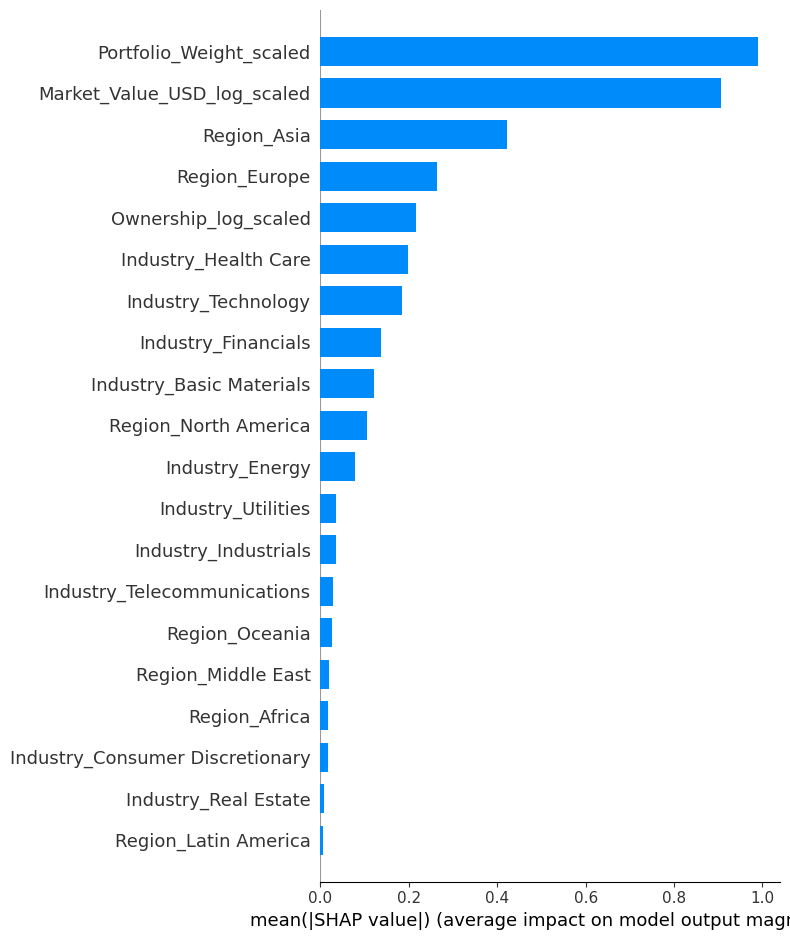


Feature importance (mean absolute SHAP values):


,feature,mean_abs_shap
0,Portfolio_Weight_scaled,0.990171
1,Market_Value_USD_log_scaled,0.906611
2,Region_Asia,0.422945
3,Region_Europe,0.263834
4,Ownership_log_scaled,0.216434
5,Industry_Health Care,0.198222
6,Industry_Technology,0.184183
7,Industry_Financials,0.137029
8,Industry_Basic Materials,0.121679
9,Region_North America,0.104590



XGBoost


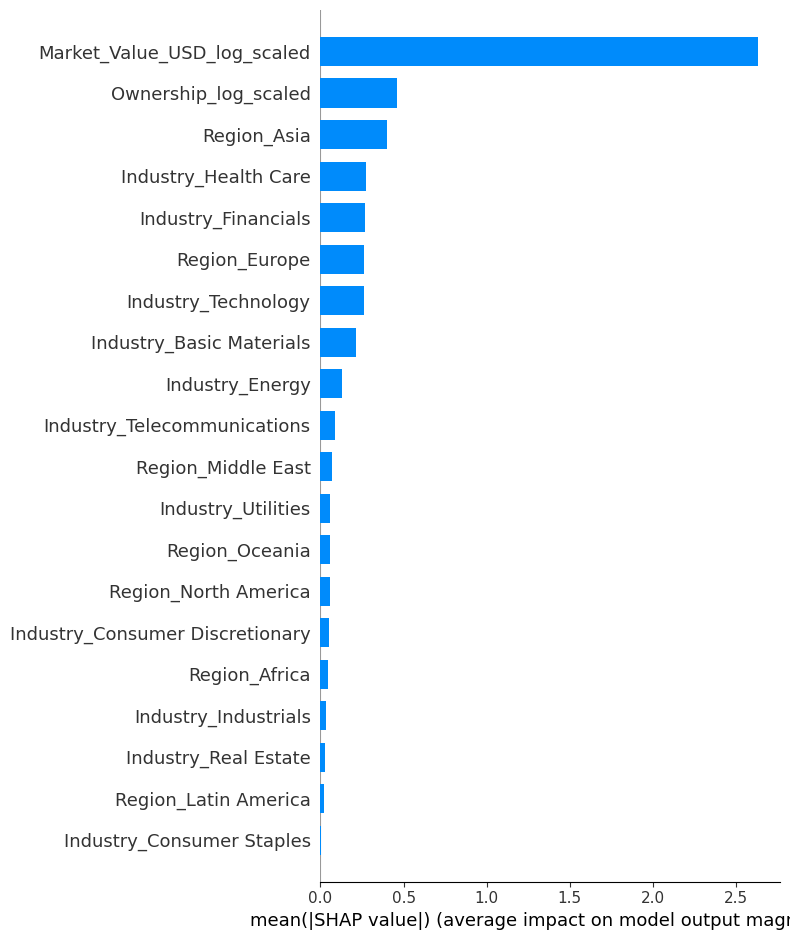


Feature importance (mean absolute SHAP values):


,feature,mean_abs_shap
0,Market_Value_USD_log_scaled,2.632569
1,Ownership_log_scaled,0.461603
2,Region_Asia,0.399910
3,Industry_Health Care,0.273340
4,Industry_Financials,0.266852
5,Region_Europe,0.264531
6,Industry_Technology,0.260665
7,Industry_Basic Materials,0.211403
8,Industry_Energy,0.130595
9,Industry_Telecommunications,0.088384


In [36]:
# Saving the best models and performing SHAP analysis for 'Environmental' variable
saved_models_env = save_and_analyze_top2(
    results_env, models_env, X_train, y_train, X_test,
    'Environmental', base_path, shap_results
)

## Social

In [37]:
# Social# component as a target
X_train, X_test, y_train, y_test = prepare_data(esg_2024, 'Social')
results_soc, top4_soc, models_soc = run_ml_pipeline(X_train, X_test, y_train, y_test, 'Social')



Train: 6695 samples | Positive: 414 (6.2%)
Test: 1674 samples

Running GridSearchCV...
  - Training Random Forest... Done
  - Training XGBoost... Done
  - Training CatBoost... Done
  - Training LightGBM... Done
  - Training AdaBoost... Done
  - Training HistGradientBoosting... Done

Top Models by PR-AUC:


,scoring,model,best_params,accuracy,precision_macro,recall_macro,f1_macro,pr_auc
2,average_precision,CatBoost,"{'depth': 6, 'iterations': 400, 'learning_rate...",0.827360,0.620064,0.854091,0.644242,0.516708
0,average_precision,Random Forest,"{'class_weight': 'balanced', 'max_depth': 5, '...",0.829749,0.615000,0.828430,0.638893,0.481698
5,average_precision,HistGradientBoosting,"{'learning_rate': 0.1, 'max_depth': 3, 'max_it...",0.831541,0.620379,0.847342,0.645949,0.479501
1,average_precision,XGBoost,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.829152,0.620038,0.850557,0.644792,0.466513
3,average_precision,LightGBM,"{'learning_rate': 0.01, 'n_estimators': 100, '...",0.912784,0.683718,0.814337,0.726113,0.432700
4,average_precision,AdaBoost,"{'learning_rate': 0.5, 'n_estimators': 100}",0.940263,0.792814,0.541677,0.560791,0.427569



Evaluating Top 4 Models:
  CatBoost: PR-AUC=0.5167, F1=0.3890
  Random Forest: PR-AUC=0.4817, F1=0.3764
  HistGradientBoosting: PR-AUC=0.4795, F1=0.3896
  XGBoost: PR-AUC=0.4665, F1=0.3889


Saving top 2 models to: /content/drive/MyDrive/Mis estudios /the_fund/models_social
  Saved: CatBoost.pkl
  Saved: Random_Forest.pkl

Running SHAP analysis for top 2 models...

CatBoost


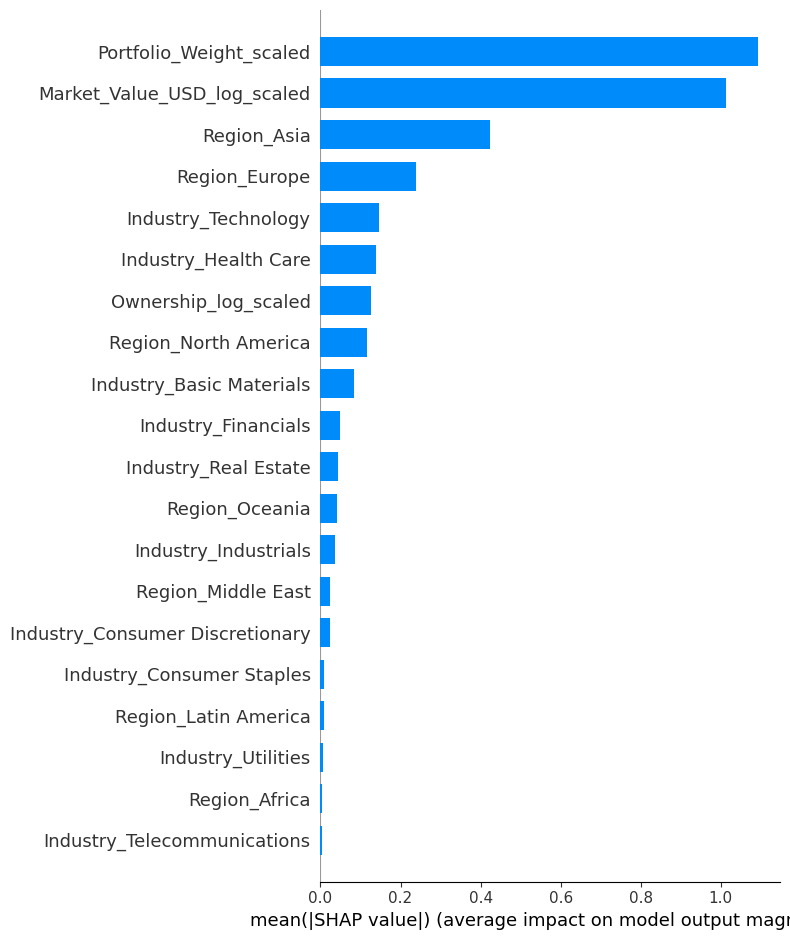


Feature importance (mean absolute SHAP values):


,feature,mean_abs_shap
0,Portfolio_Weight_scaled,1.093130
1,Market_Value_USD_log_scaled,1.011703
2,Region_Asia,0.422722
3,Region_Europe,0.238900
4,Industry_Technology,0.147391
5,Industry_Health Care,0.138529
6,Ownership_log_scaled,0.126884
7,Region_North America,0.115205
8,Industry_Basic Materials,0.083474
9,Industry_Financials,0.049898



Random Forest


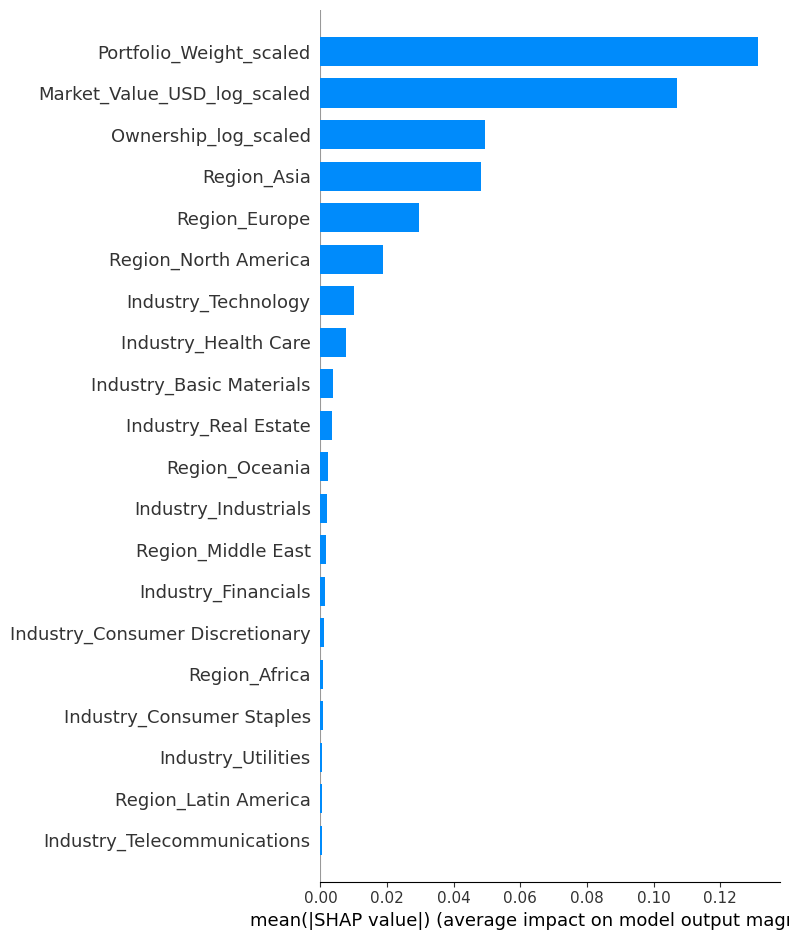


Feature importance (mean absolute SHAP values):


,feature,mean_abs_shap
0,Portfolio_Weight_scaled,0.131356
1,Market_Value_USD_log_scaled,0.107039
2,Ownership_log_scaled,0.049409
3,Region_Asia,0.048056
4,Region_Europe,0.029558
5,Region_North America,0.018810
6,Industry_Technology,0.010095
7,Industry_Health Care,0.007806
8,Industry_Basic Materials,0.003693
9,Industry_Real Estate,0.003508


In [38]:
saved_models_soc = save_and_analyze_top2(
    results_soc, models_soc, X_train, y_train, X_test,
    'Social', base_path, shap_results
)

## Governance

In [39]:
# Governance component as a target
X_train, X_test, y_train, y_test = prepare_data(esg_2024, 'Governance')
results_gov, top4_gov, models_gov = run_ml_pipeline(X_train, X_test, y_train, y_test, 'Governance')



Train: 6695 samples | Positive: 622 (9.3%)
Test: 1674 samples

Running GridSearchCV...
  - Training Random Forest... Done
  - Training XGBoost... Done
  - Training CatBoost... Done
  - Training LightGBM... Done
  - Training AdaBoost... Done
  - Training HistGradientBoosting... Done

Top Models by PR-AUC:


,scoring,model,best_params,accuracy,precision_macro,recall_macro,f1_macro,pr_auc
2,average_precision,CatBoost,"{'depth': 6, 'iterations': 200, 'learning_rate...",0.869773,0.684564,0.823963,0.723275,0.642205
1,average_precision,XGBoost,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.835723,0.664516,0.848650,0.697758,0.641056
5,average_precision,HistGradientBoosting,"{'learning_rate': 0.1, 'max_depth': 5, 'max_it...",0.853047,0.676468,0.849506,0.714564,0.640831
3,average_precision,LightGBM,"{'learning_rate': 0.1, 'n_estimators': 100, 'n...",0.886499,0.706810,0.841870,0.748505,0.630754
0,average_precision,Random Forest,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.894863,0.714530,0.823305,0.752287,0.622563
4,average_precision,AdaBoost,"{'learning_rate': 1.0, 'n_estimators': 100}",0.918757,0.758887,0.743779,0.751024,0.605985



Evaluating Top 4 Models:
  CatBoost: PR-AUC=0.6422, F1=0.5219
  XGBoost: PR-AUC=0.6411, F1=0.4936
  HistGradientBoosting: PR-AUC=0.6408, F1=0.5157
  LightGBM: PR-AUC=0.6308, F1=0.5622


Saving top 2 models to: /content/drive/MyDrive/Mis estudios /the_fund/models_governance
  Saved: CatBoost.pkl
  Saved: XGBoost.pkl

Running SHAP analysis for top 2 models...

CatBoost


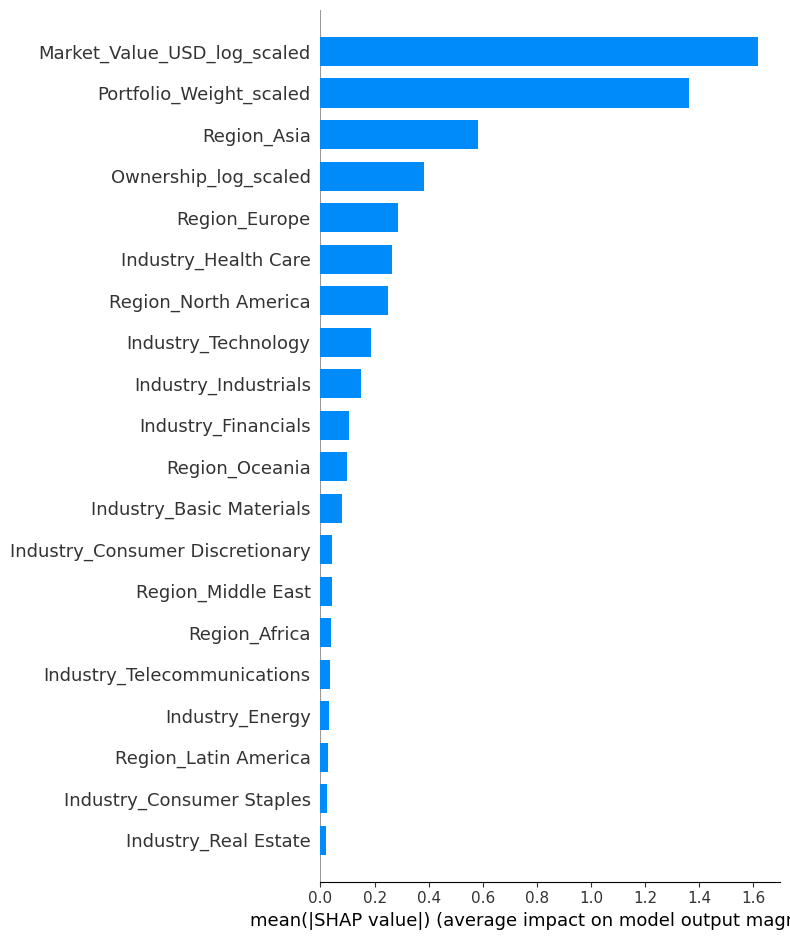


Feature importance (mean absolute SHAP values):


,feature,mean_abs_shap
0,Market_Value_USD_log_scaled,1.617902
1,Portfolio_Weight_scaled,1.363478
2,Region_Asia,0.583731
3,Ownership_log_scaled,0.382059
4,Region_Europe,0.286301
5,Industry_Health Care,0.262917
6,Region_North America,0.248827
7,Industry_Technology,0.185496
8,Industry_Industrials,0.149482
9,Industry_Financials,0.106725



XGBoost


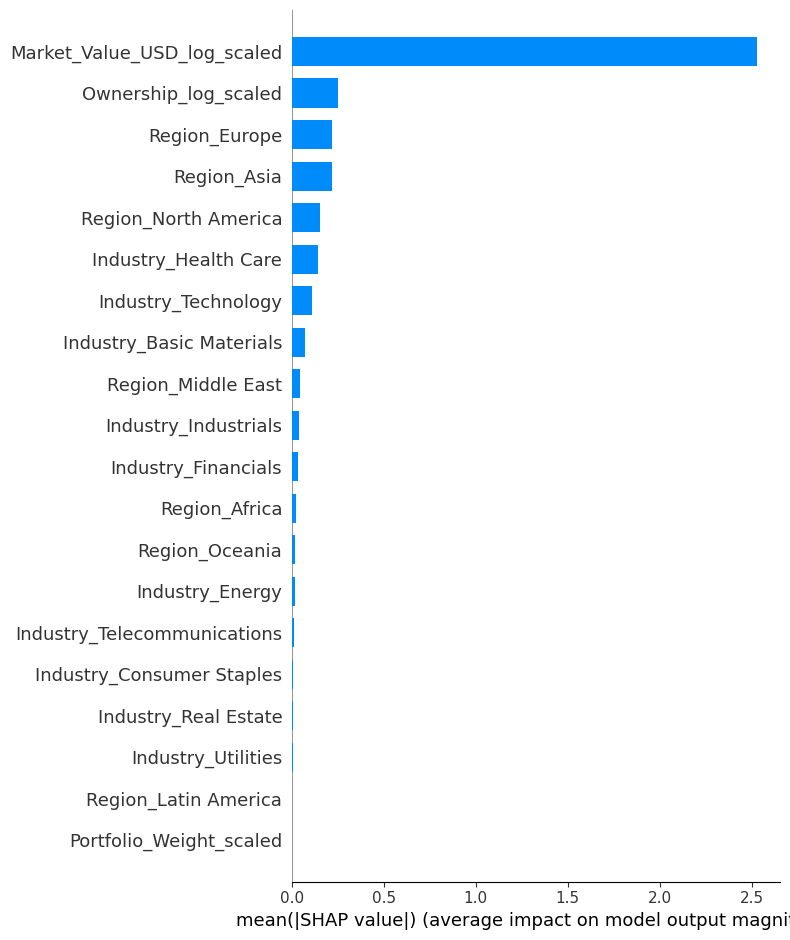


Feature importance (mean absolute SHAP values):


,feature,mean_abs_shap
0,Market_Value_USD_log_scaled,2.528542
1,Ownership_log_scaled,0.248252
2,Region_Europe,0.217198
3,Region_Asia,0.216509
4,Region_North America,0.151945
5,Industry_Health Care,0.141966
6,Industry_Technology,0.110323
7,Industry_Basic Materials,0.070079
8,Region_Middle East,0.042063
9,Industry_Industrials,0.036344


In [40]:
# Governance
saved_models_gov = save_and_analyze_top2(
    results_gov, models_gov, X_train, y_train, X_test,
    'Governance', base_path, shap_results
)

## Climate change

In [41]:
# Climate_change component as a target
X_train, X_test, y_train, y_test = prepare_data(esg_2024, 'Climate_change')
results_cc, top4_cc, models_cc = run_ml_pipeline(X_train, X_test, y_train, y_test, 'Climate_change')

Train: 6695 samples | Positive: 322 (4.8%)
Test: 1674 samples

Running GridSearchCV...
  - Training Random Forest... Done
  - Training XGBoost... Done
  - Training CatBoost... Done
  - Training LightGBM... Done
  - Training AdaBoost... Done
  - Training HistGradientBoosting... Done

Top Models by PR-AUC:


,scoring,model,best_params,accuracy,precision_macro,recall_macro,f1_macro,pr_auc
1,average_precision,XGBoost,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.855436,0.604589,0.824440,0.632342,0.460512
2,average_precision,CatBoost,"{'depth': 4, 'iterations': 200, 'learning_rate...",0.876344,0.617329,0.823708,0.653006,0.457469
5,average_precision,HistGradientBoosting,"{'learning_rate': 0.1, 'max_depth': 3, 'max_it...",0.851254,0.603246,0.828102,0.629571,0.450724
4,average_precision,AdaBoost,"{'learning_rate': 1.0, 'n_estimators': 100}",0.957587,0.843963,0.596882,0.644400,0.441535
3,average_precision,LightGBM,"{'learning_rate': 0.01, 'n_estimators': 200, '...",0.900836,0.629303,0.783846,0.667870,0.422464
0,average_precision,Random Forest,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.909797,0.638269,0.776836,0.677187,0.398410



Evaluating Top 4 Models:
  XGBoost: PR-AUC=0.4605, F1=0.3459
  CatBoost: PR-AUC=0.4575, F1=0.3746
  HistGradientBoosting: PR-AUC=0.4507, F1=0.3430
  AdaBoost: PR-AUC=0.4415, F1=0.3107


Saving top 2 models to: /content/drive/MyDrive/Mis estudios /the_fund/models_climate_change
  Saved: XGBoost.pkl
  Saved: CatBoost.pkl

Running SHAP analysis for top 2 models...

XGBoost


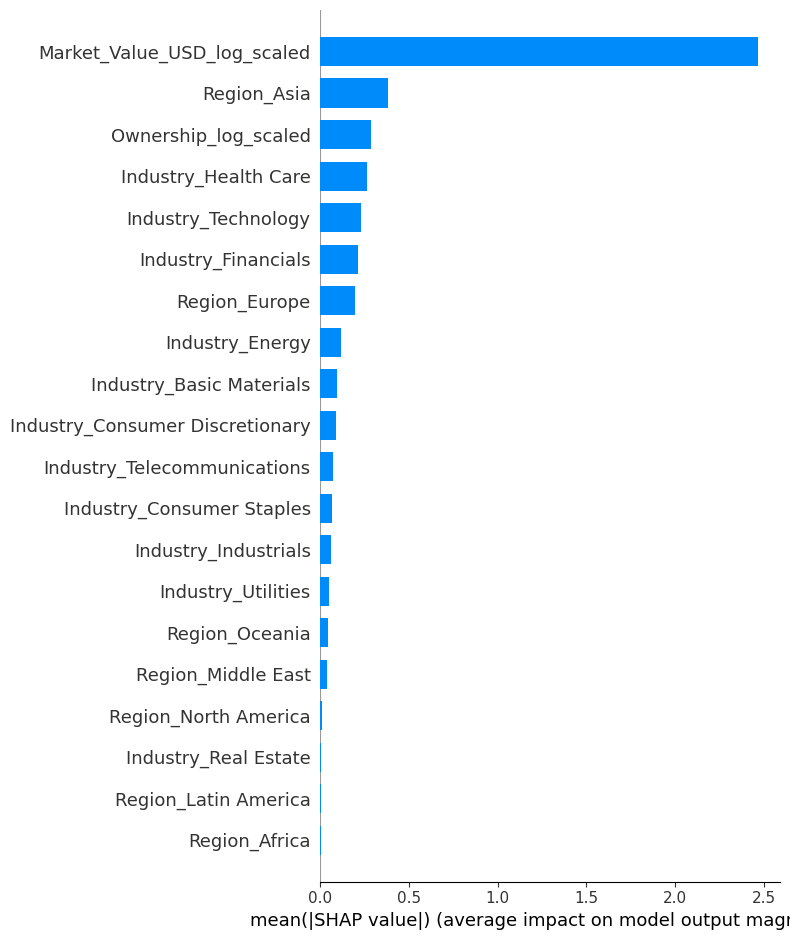


Feature importance (mean absolute SHAP values):


,feature,mean_abs_shap
0,Market_Value_USD_log_scaled,2.469183
1,Region_Asia,0.381645
2,Ownership_log_scaled,0.284549
3,Industry_Health Care,0.260189
4,Industry_Technology,0.229422
5,Industry_Financials,0.211455
6,Region_Europe,0.195846
7,Industry_Energy,0.118467
8,Industry_Basic Materials,0.090800
9,Industry_Consumer Discretionary,0.086581



CatBoost


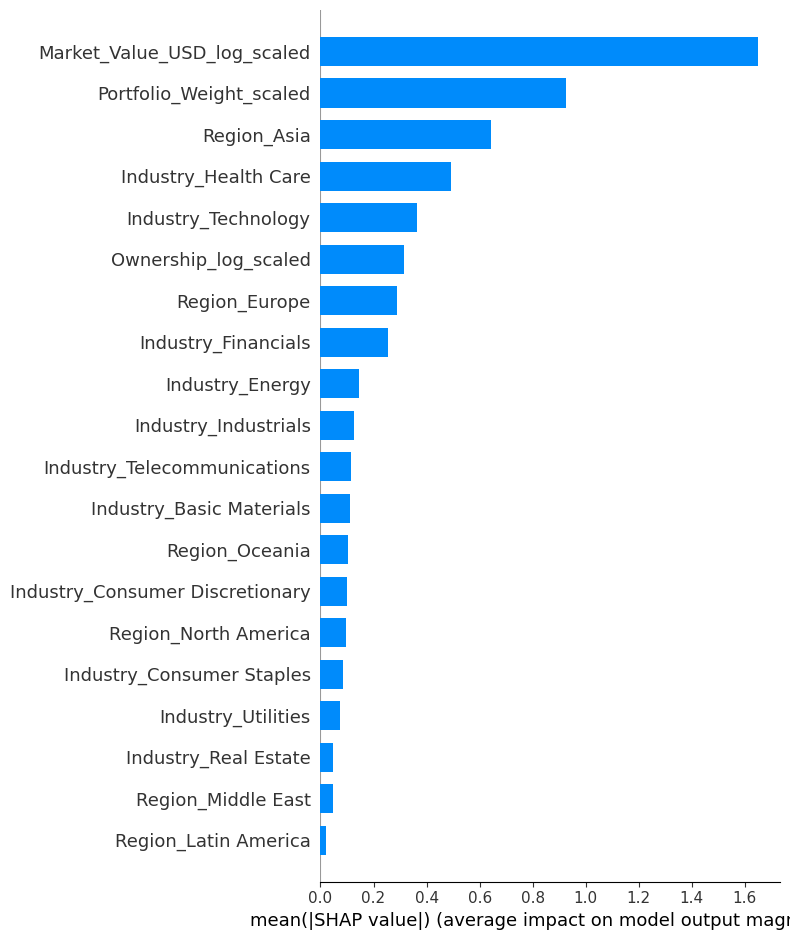


Feature importance (mean absolute SHAP values):


,feature,mean_abs_shap
0,Market_Value_USD_log_scaled,1.649732
1,Portfolio_Weight_scaled,0.924911
2,Region_Asia,0.642224
3,Industry_Health Care,0.490709
4,Industry_Technology,0.362598
5,Ownership_log_scaled,0.314929
6,Region_Europe,0.287140
7,Industry_Financials,0.253041
8,Industry_Energy,0.144549
9,Industry_Industrials,0.124707


In [42]:
# Climate_change
saved_models_cc = save_and_analyze_top2(
    results_cc, models_cc, X_train, y_train, X_test,
    'Climate_change', base_path, shap_results
)

## Discussion of the results of the section

In [43]:
# Comparative Analysis Across ESG Components

#  Build comprehensive comparison DataFrame
comparative_df = pd.DataFrame({
    'Target': ['Environmental', 'Social', 'Governance', 'Climate_change'],
    'Positive_Class_Pct': [
        esg_2024['Environmental'].mean() * 100,
        esg_2024['Social'].mean() * 100,
        esg_2024['Governance'].mean() * 100,
        esg_2024['Climate_change'].mean() * 100
    ],
    'Best_Model': [
        results_env.iloc[0]['model'],
        results_soc.iloc[0]['model'],
        results_gov.iloc[0]['model'],
        results_cc.iloc[0]['model']
    ],
    'Best_PR_AUC': [
        results_env.iloc[0]['pr_auc'],
        results_soc.iloc[0]['pr_auc'],
        results_gov.iloc[0]['pr_auc'],
        results_cc.iloc[0]['pr_auc']
    ]
})

# Add top features from SHAP
top_features = []
top_shap_values = []

for target in ['Environmental', 'Social', 'Governance', 'Climate_change']:
    best_model_name = list(shap_results[target].keys())[0]
    top_feat = shap_results[target][best_model_name].iloc[0]
    top_features.append(top_feat['feature'])
    top_shap_values.append(top_feat['mean_abs_shap'])

comparative_df['Top_Feature'] = top_features
comparative_df['Top_Feature_SHAP'] = top_shap_values

# Sort by PR-AUC
comparative_df = comparative_df.sort_values('Best_PR_AUC', ascending=False).reset_index(drop=True)

print("Comprehensive Comparison Across ESG Components:")
display(comparative_df)

Comprehensive Comparison Across ESG Components:


,Target,Positive_Class_Pct,Best_Model,Best_PR_AUC,Top_Feature,Top_Feature_SHAP
0,Governance,9.284263,CatBoost,0.642205,Market_Value_USD_log_scaled,1.617902
1,Environmental,6.141713,CatBoost,0.520167,Portfolio_Weight_scaled,0.990171
2,Social,6.189509,CatBoost,0.516708,Portfolio_Weight_scaled,1.093130
3,Climate_change,4.815390,XGBoost,0.460512,Market_Value_USD_log_scaled,2.469183


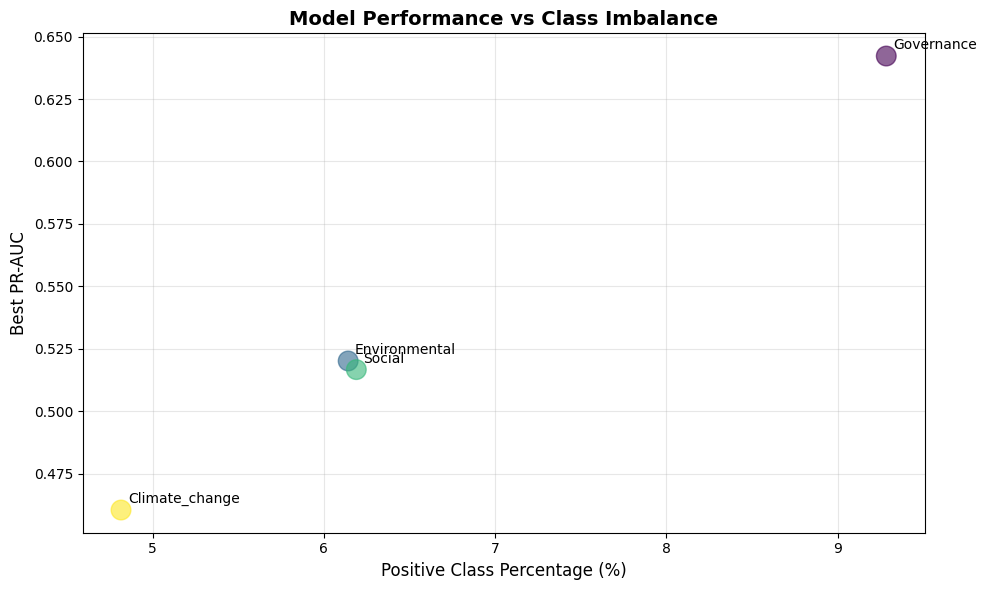

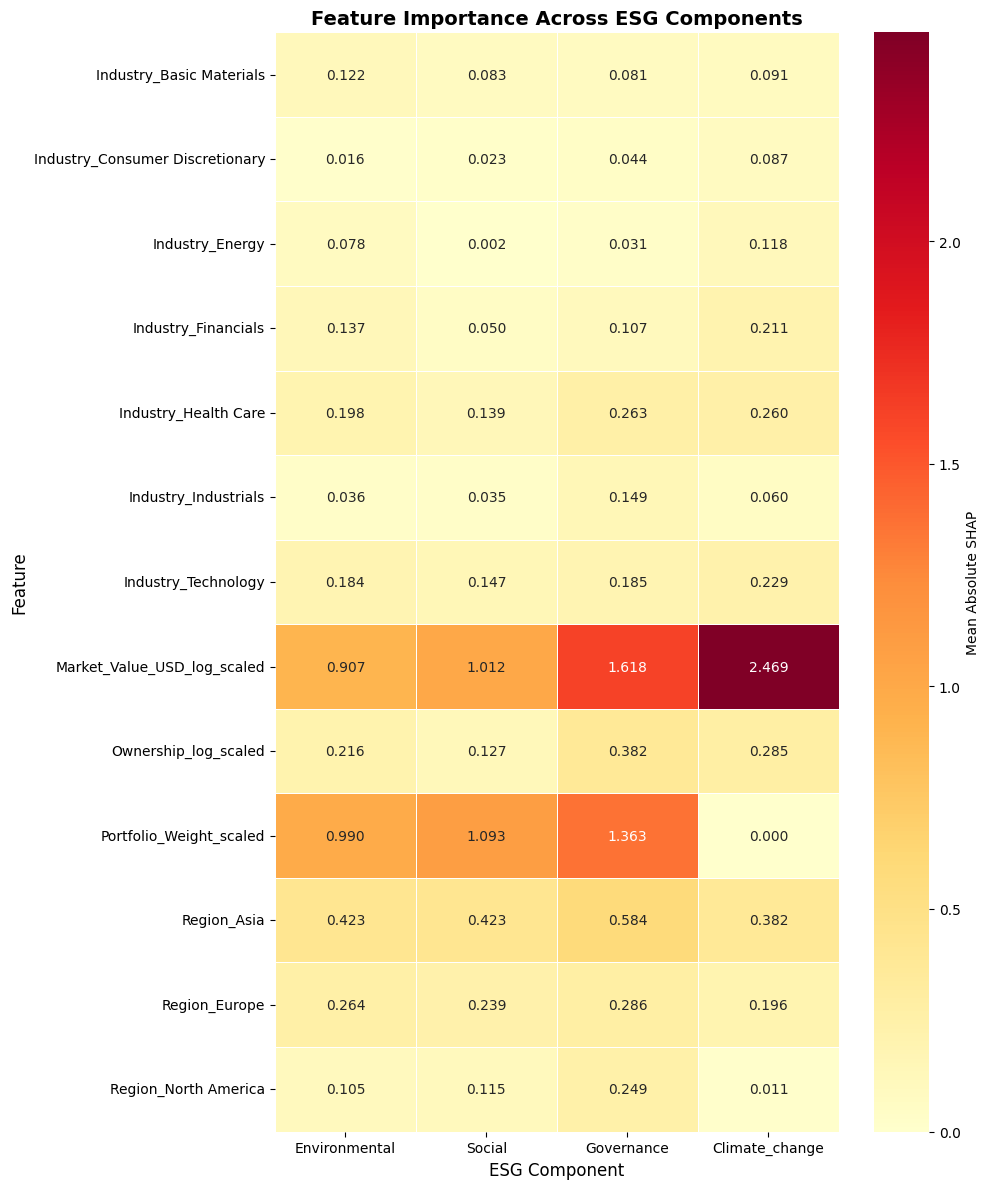

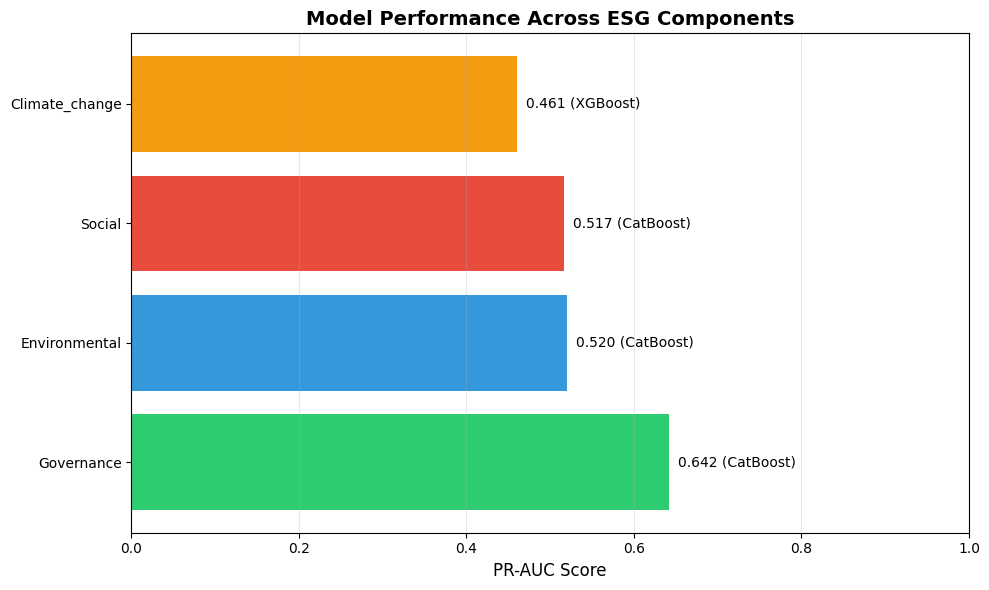

In [44]:

# Visualization 1: PR-AUC vs Class Imbalance
fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(comparative_df['Positive_Class_Pct'],
                     comparative_df['Best_PR_AUC'],
                     s=200, alpha=0.6, c=range(len(comparative_df)), cmap='viridis')

for idx, row in comparative_df.iterrows():
    ax.annotate(row['Target'],
                (row['Positive_Class_Pct'], row['Best_PR_AUC']),
                xytext=(5, 5), textcoords='offset points', fontsize=10)

ax.set_xlabel('Positive Class Percentage (%)', fontsize=12)
ax.set_ylabel('Best PR-AUC', fontsize=12)
ax.set_title('Model Performance vs Class Imbalance', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Visualization 2: Feature Importance Heatmap
# Get top 10 features across all targets
all_features = set()
for target, models in shap_results.items():
    best_model = list(models.keys())[0]
    top_10 = models[best_model].head(10)['feature'].values
    all_features.update(top_10)

# Build importance matrix
importance_matrix = pd.DataFrame(0.0,
                                 index=sorted(all_features),
                                 columns=['Environmental', 'Social', 'Governance', 'Climate_change'])

for target, models in shap_results.items():
    best_model = list(models.keys())[0]
    feat_imp = models[best_model].set_index('feature')['mean_abs_shap']
    for feat in importance_matrix.index:
        if feat in feat_imp.index:
            importance_matrix.loc[feat, target] = feat_imp[feat]

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 12))
sns.heatmap(importance_matrix, annot=True, fmt='.3f', cmap='YlOrRd',
            linewidths=0.5, cbar_kws={'label': 'Mean Absolute SHAP'})
ax.set_title('Feature Importance Across ESG Components', fontsize=14, fontweight='bold')
ax.set_xlabel('ESG Component', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()


# Visualization 3: Bar chart - PR-AUC comparison
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(comparative_df['Target'], comparative_df['Best_PR_AUC'],
               color=['#2ecc71', '#3498db', '#e74c3c', '#f39c12'])

ax.set_xlabel('PR-AUC Score', fontsize=12)
ax.set_title('Model Performance Across ESG Components', fontsize=14, fontweight='bold')
ax.set_xlim(0, 1)

# Add values on bars
for i, (idx, row) in enumerate(comparative_df.iterrows()):
    ax.text(row['Best_PR_AUC'] + 0.01, i,
            f"{row['Best_PR_AUC']:.3f} ({row['Best_Model']})",
            va='center', fontsize=10)

ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

**Discussion of the results**

The analysis reveals meaningful variation in predictive performance across ESG dimensions.

- Governance controversies demonstrate the strongest predictability (PR-AUC=0.642), a moderate result that suggests identifiable but imperfect patterns in the data.

- Climate_change presents the greatest modeling challenge (PR-AUC=0.461), approaching random performance and indicating weak predictive signals from available features, which can be explained by the fact that it is the variable with the least ammount of frequencies.

 - Environmental and Social components achieve similar modest performance (0.520 and 0.517), sufficient for screening applications but requiring cautious interpretation of model outputs.

These performance levels, while below what would be considered strong (>0.75), remain practically useful for risk flagging rather than definitive exclusions. The 18 percentage point spread between Governance and Climate_change reveals that not all ESG dimensions are equally amenable to prediction from company characteristics alone, suggesting certain controversies may be more idiosyncratic or event-driven than structurally determined.

As for the top performing models, CatBoost emerges as the dominant algorithm, achieving top performance for Governance, Environmental, and Social components, with only Climate_change favoring XGBoost. CatBoost's superiority likely stems from its native handling of categorical features (Region and Industry dummies) and its ordered boosting mechanism that reduces overfitting on imbalanced datasets.

**Comments on SHAP Analysis**

- Feature importance patterns reveal distinct risk drivers across components. Market_Value_USD_log_scaled dominates Governance and Climate_change predictions, suggesting that **larger companies face greater scrutiny and disclosure requirements in these dimensions.**

- Corporate governance failures and climate-related controversies are more visible and consequential for major corporations, making size a strong signal.

-  Conversely, Portfolio_Weight_scaled leads Environmental and Social predictions, indicating that companies with higher fund allocations may reflect selection biases toward firms with stronger operational practices in these areas, or alternatively, that portfolio managers have already screened for basic environmental and social risks.

- The substantially higher SHAP value for market value in Climate_change (2.62) compared to Governance (1.49) warrants attention. This disparity suggests climate controversies disproportionately affect large corporations, possibly due to their carbon-intensive operations at scale, heightened regulatory exposure, or greater public pressure for climate disclosures.

- Environmental controversies, while related, show weaker dependence on size, implying that pollution and resource management issues affect companies more uniformly across market capitalizations.

- While Region and Industry features contributed to predictions, the dominance of size and portfolio metrics in SHAP rankings suggests categorical features play a supporting rather than leading role..

